In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
pd.set_option('display.max_columns', None)
import math
from scipy.integrate import odeint
import matplotlib.animation
from IPython.display import Image, HTML, display

In [27]:
def save_animation(data, left_column, left_colors, right_columns, right_colors, name):
    fig, ax = plt.subplots()
    fig.set_size_inches(w=15, h=7)

    left_lines = [ax.plot(data.index, data[l], color=c, label=l)[0] for l, c in zip(left_columns, left_colors)]

    ax_right = ax.twinx()
    right_lines = [ax_right.plot(data.index, data[l], color=c, label=l)[0] for l, c in zip(right_columns, right_colors)]

    lines = left_lines + right_lines
    columns = left_columns + right_columns
    ax.legend(lines, columns)

    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.94)
    # todo try fig.tight_layout()

    plt.title(name, fontsize=30)
    plt.savefig('img-generated/' + name + '.png', dpi=100)

    animate = lambda i: [line.set_data(data.index[:i], data[column].iloc[:i]) 
                         for (line, column) in zip(lines, columns)]

    frames = np.linspace(0, data.shape[0] - 1, 125, dtype=np.int)
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=40)

    ani.save('img-generated/' + name + '.gif', writer="imagemagick", dpi=100, fps=25)

mash tun dimensions

In [3]:
radius = 0.15
height = 0.75

In [4]:
volume = math.pi * math.pow(radius, 2) * height
volume

0.053014376029327764

In [5]:
surface = 2 * math.pi * radius * height + 2 * math.pi * math.pow(radius, 2)
surface

0.8482300164692441

In [6]:
# specific heat https://en.wikipedia.org/wiki/Heat_capacity#Measurement
# in J/(kg⋅K)
Cp = 3000
heat_capacity = Cp * volume * 1000

# air convection, in W/(m^2*K)
heat_transfer_coefficient = 30

In [7]:
# ambient heat loss in Watts
heat_transfer_coefficient * surface * (75 - 25)

1272.345024703866

In [8]:
# time to heat to target temperature (seconds)
heat_capacity * (75 - 50) / 3000

1325.3594007331942

In [9]:
# https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling
def temperature_derivative(temperature, time, power, external_temperature, 
                  heat_capacity, heat_transfer_coefficient, surface):
    return (power - heat_transfer_coefficient * surface * (temperature - external_temperature)) / heat_capacity

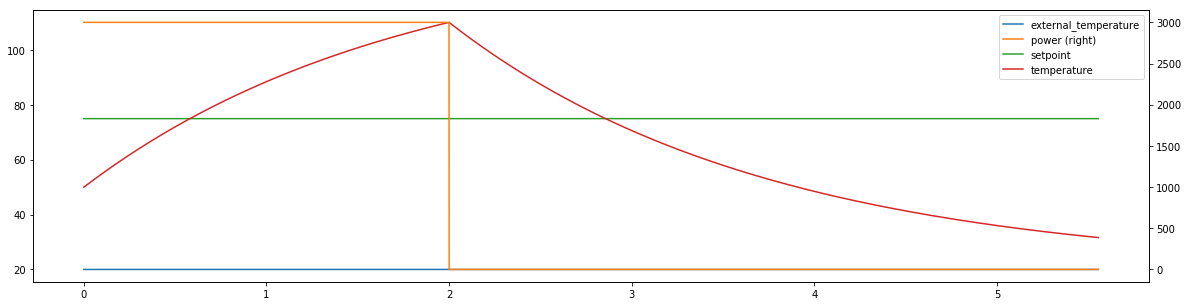

In [28]:
time = np.arange(0, 20000, 1, dtype=np.float64)
power = np.full_like(time, 3000)
power[7200:] = 0
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 75)

for i in range(len(time) - 1):
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.plot(secondary_y=('power'));

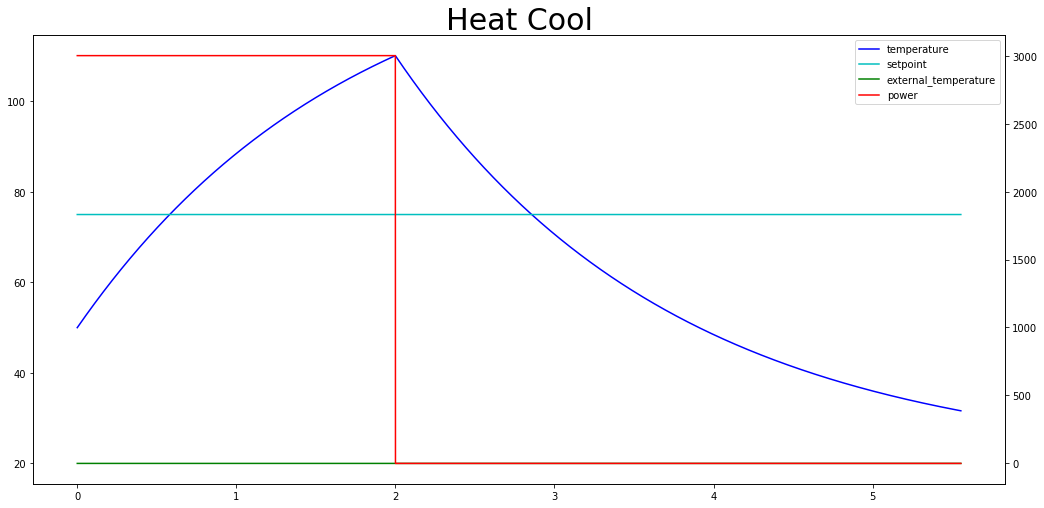

In [29]:
left_columns = ['temperature', 'setpoint', 'external_temperature']
left_colors = ['b', 'c', 'g']

right_columns = ['power']
right_colors = ['r']

save_animation(data, left_columns, left_colors, right_columns, right_colors, 'Heat Cool')